In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# ====== Cell 1: Imports and setup ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error
)
import xgboost as xgb
import glob
import os

sns.set(style="whitegrid", font_scale=1.1)
print("Using XGBoost from:", xgb.__file__)


Using XGBoost from: c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\__init__.py


In [16]:
# ====== Cell 2: Load patient data ======
path = r"C:\Users\Lenovo\Documents\690\Project\HUPA-UCM Diabetes Dataset\Preprocessed"
all_files = sorted(glob.glob(os.path.join(path, "HUPA*.csv")))
print(f"Found {len(all_files)} patient files.")

patients_data = []
for i, file in enumerate(all_files):
    df = pd.read_csv(file, sep=';')
    df.columns = df.columns.str.strip()
    df['time'] = pd.to_datetime(df['time'])
    df['patient_id'] = i + 1
    
    # Calculate total insulin
    df['total_insulin'] = df['basal_rate'] + df['bolus_volume_delivered']
    
    # Lag features
    df['glucose_lag_5'] = df['glucose'].shift(1).fillna(method='bfill')
    df['glucose_lag_10'] = df['glucose'].shift(2).fillna(method='bfill')
    
    # Time features
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    
    patients_data.append(df)

# Combine all patients
data = pd.concat(patients_data, ignore_index=True)
print("Total records:", len(data))
data.head()


Found 25 patient files.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17328\1897419523.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['glucose_lag_5'] = df['glucose'].shift(1).fillna(method='bfill')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17328\1897419523.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['glucose_lag_10'] = df['glucose'].shift(2).fillna(method='bfill')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17328\1897419523.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['glucose_lag_5'] = df['glucose'].shift(1).fillna(method='bfill')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17328\1897419523.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or ob

Total records: 309392


,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,patient_id,total_insulin,glucose_lag_5,glucose_lag_10,hour,minute
0,2018-06-13 18:40:00,332.0,6.3595,82.322835,34.0,0.091667,0.0,0.0,1,0.091667,332.0,332.0,18,40
1,2018-06-13 18:45:00,326.0,7.7280,83.740157,0.0,0.091667,0.0,0.0,1,0.091667,332.0,332.0,18,45
2,2018-06-13 18:50:00,330.0,4.7495,80.525180,0.0,0.091667,0.0,0.0,1,0.091667,326.0,332.0,18,50
3,2018-06-13 18:55:00,324.0,6.3595,89.129032,20.0,0.091667,0.0,0.0,1,0.091667,330.0,326.0,18,55
4,2018-06-13 19:00:00,306.0,5.1520,92.495652,0.0,0.075000,0.0,0.0,1,0.075000,324.0,330.0,19,0


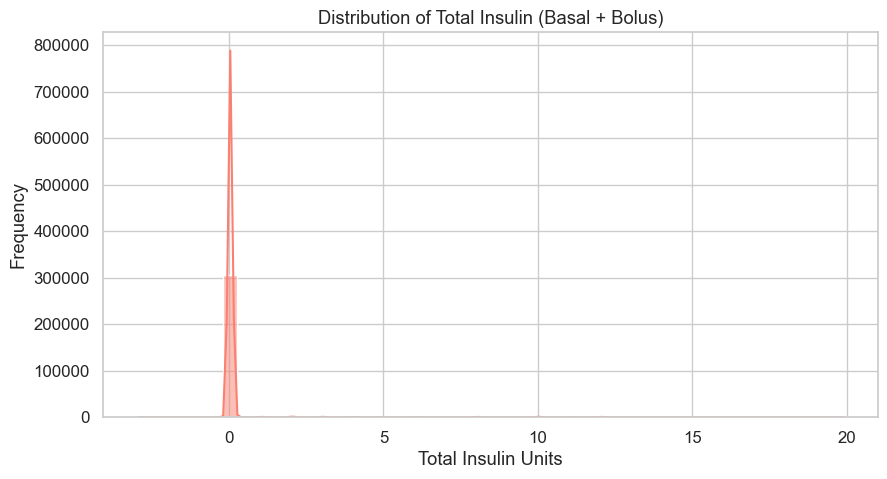

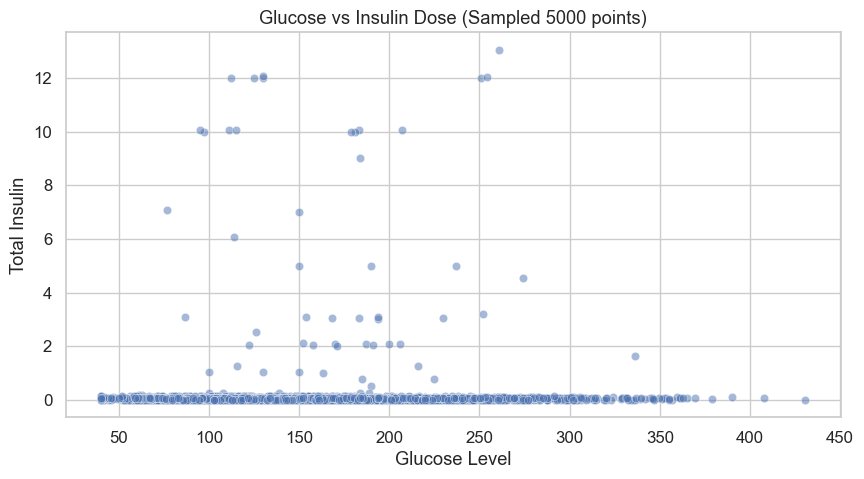

In [17]:
# ====== Cell 3: Visualize key distributions ======
plt.figure(figsize=(10,5))
sns.histplot(data['total_insulin'], bins=50, kde=True, color='salmon')
plt.title("Distribution of Total Insulin (Basal + Bolus)")
plt.xlabel("Total Insulin Units")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x='glucose', y='total_insulin', data=data.sample(5000), alpha=0.5)
plt.title("Glucose vs Insulin Dose (Sampled 5000 points)")
plt.xlabel("Glucose Level")
plt.ylabel("Total Insulin")
plt.show()


In [18]:
# ====== Cell 4: Features and target ======
features = [
    'glucose', 'carb_input', 'heart_rate', 'steps', 'calories',
    'glucose_lag_5', 'glucose_lag_10', 'hour', 'minute'
]
target = 'total_insulin'

X = data[features]
y = data[target]

# Shuffle dataset
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
X = data_shuffled[features]
y = data_shuffled[target]

# Split: 70% train, 15% val, 15% test
n = len(X)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 216574
Validation samples: 46409
Testing samples: 46409


C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


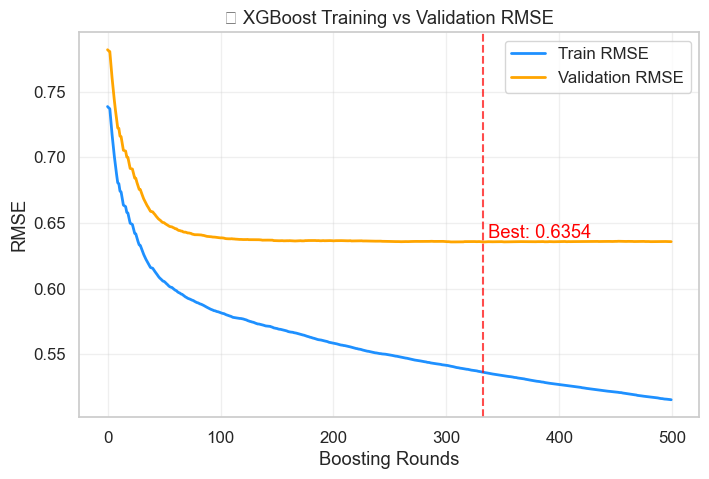

✅ Best iteration: 332
🔹 Final Train RMSE: 0.5153
🔹 Best Validation RMSE: 0.6354


In [19]:
# ====== Cell 5: Train XGBoost model ======
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='rmse'
)

# Fit model
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# Training history
evals_result = xgb_model.evals_result()
train_rmse = evals_result['validation_0']['rmse']
val_rmse = evals_result['validation_1']['rmse']
epochs = len(train_rmse)
x_axis = range(epochs)

# Plot training curve
plt.figure(figsize=(8,5))
plt.plot(x_axis, train_rmse, label='Train RMSE', color='dodgerblue', linewidth=2)
plt.plot(x_axis, val_rmse, label='Validation RMSE', color='orange', linewidth=2)
best_iter = val_rmse.index(min(val_rmse))
plt.axvline(best_iter, color='red', linestyle='--', alpha=0.7)
plt.text(best_iter, min(val_rmse), f" Best: {min(val_rmse):.4f}", color='red', va='bottom')
plt.title("📉 XGBoost Training vs Validation RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"✅ Best iteration: {best_iter}")
print(f"🔹 Final Train RMSE: {train_rmse[-1]:.4f}")
print(f"🔹 Best Validation RMSE: {min(val_rmse):.4f}")


In [20]:
# ====== Cell 6: Model evaluation ======
def evaluate_model(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {dataset_name} Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")
    return rmse, mae, r2

y_val_pred = xgb_model.predict(X_val_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

evaluate_model(y_val, y_val_pred, "Validation Set")
evaluate_model(y_test, y_test_pred, "Test Set")



📊 Validation Set Evaluation:
RMSE: 0.6357
MAE: 0.1142
R²:  0.3573

📊 Test Set Evaluation:
RMSE: 0.6164
MAE: 0.1149
R²:  0.3273


(np.float64(0.616422324603055), 0.11493043092323045, 0.3273497063276941)

In [22]:
# ====== Cell 7: Metrics summary table (fixed) ======
metrics = {
    'Dataset': ['Validation', 'Test'],
    'RMSE': [np.sqrt(mean_squared_error(y_val, y_val_pred)),
             np.sqrt(mean_squared_error(y_test, y_test_pred))],
    'MAE': [mean_absolute_error(y_val, y_val_pred),
            mean_absolute_error(y_test, y_test_pred)],
    'R² Score': [r2_score(y_val, y_val_pred),
                 r2_score(y_test, y_test_pred)]
}

metrics_df = pd.DataFrame(metrics)

display(
    metrics_df.style
    .set_caption("📊 Insulin Prediction Performance Summary")
    .format({
        "RMSE": "{:.4f}",
        "MAE": "{:.4f}",
        "R² Score": "{:.4f}"
    })
    .background_gradient(subset=["R² Score"], cmap="Greens")
    .background_gradient(subset=["RMSE","MAE"], cmap="Reds_r")
)


,Dataset,RMSE,MAE,R² Score
0,Validation,0.6357,0.1142,0.3573
1,Test,0.6164,0.1149,0.3273


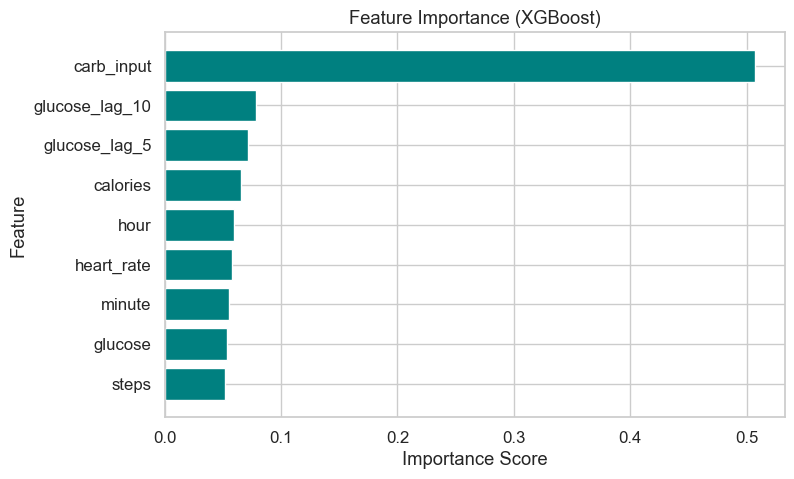

In [23]:
# ====== Cell 8: Feature importance ======
importances = xgb_model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8,5))
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx], color='teal')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


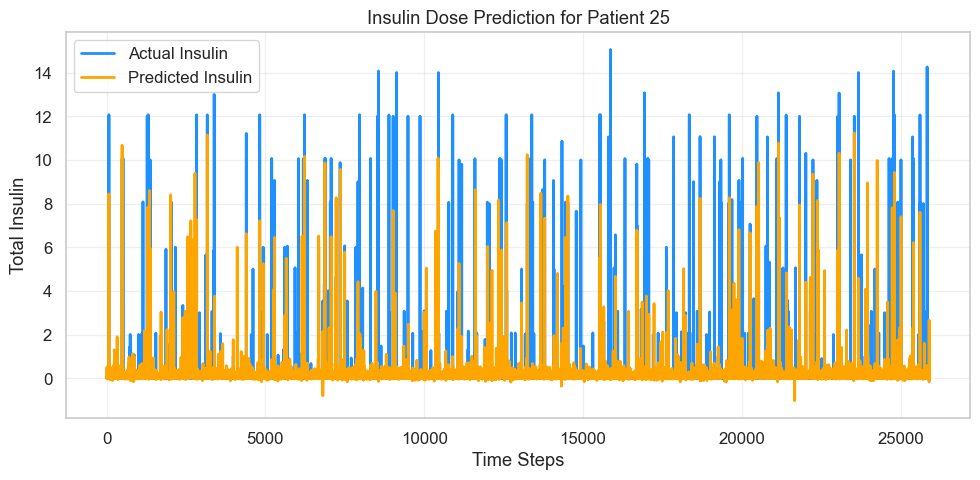

In [24]:
# ====== Cell 9: Sample patient insulin prediction ======
sample_patient = 25

# Mask within test set
test_mask = (data['patient_id'] == sample_patient) & (data.index >= X_test.index[0])
patient_X = X_test_scaled[data.index[test_mask] - X_test.index[0]]
patient_y = y_test.loc[data.index[test_mask]]
patient_pred = xgb_model.predict(patient_X)

plt.figure(figsize=(10,5))
plt.plot(patient_y.values, label='Actual Insulin', color='dodgerblue', linewidth=2)
plt.plot(patient_pred, label='Predicted Insulin', color='orange', linewidth=2)
plt.title(f"Insulin Dose Prediction for Patient {sample_patient}")
plt.xlabel("Time Steps")
plt.ylabel("Total Insulin")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
